In [1]:
import os
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split

from fiber_predictor.svr_hog.data_processing import HogDataset
from fiber_predictor.svr_hog.models import FiberPredictor

/opt/homebrew/Caskroom/miniconda/base/envs/fiber_predictor/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/fiber_predictor/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /opt/homebrew/Caskroom/miniconda/base/envs/fiber_predictor/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/homebrew/Caskroom/miniconda/base/envs/fiber_predictor/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
FILE_DIR_BIO = "../images/bio/"
LABELS_PATH_BIO = "../images/bio/labels.csv"
FILE_DIR_DIFF = "../images/diffusion/diffusion_voxels/"
LABELS_PATH_DIFF = "../images/diffusion/diffusion_voxels/labels.csv"

GRID_QUOTIENT = np.arange(1, 6)
ORIENTATIONS = 10
BATCH_SIZE = 32
TRAIN_TEST_SPLIT_RATIO = 0.3


In [3]:
# Model parameters
SCALER_TYPE = "Standard"  # Options: 'Standard', 'MinMax', 'Cosine'
PCA_PARAMS = {"n_components": 0.95}  # Retain 95% variance
REGRESSOR_TYPE = "SVR"  # Options: 'SVR', 'LinearRegression', 'Ridge', etc.
REGRESSOR_PARAMS = {"kernel": "rbf", "C": 100, "gamma": 0.01}

In [4]:
# Load biological data
bio_dataset = HogDataset(
    labels_path=LABELS_PATH_BIO,
    file_dir=FILE_DIR_BIO,
    grid_quotient=GRID_QUOTIENT,
    orientations=ORIENTATIONS,
    augment_whole_dataset=True
)

# Load diffusion data
diff_dataset = HogDataset(
    labels_path=LABELS_PATH_DIFF,
    file_dir=FILE_DIR_DIFF,
    grid_quotient=GRID_QUOTIENT,
    orientations=ORIENTATIONS,
    augment_whole_dataset=False
)

In [5]:
# Split the datasets
def split_dataset(dataset, split_ratio):
    train_size = int((1 - split_ratio) * len(dataset))
    test_size = len(dataset) - train_size
    return random_split(dataset, [train_size, test_size])

bio_train_dataset, bio_test_dataset = split_dataset(bio_dataset, TRAIN_TEST_SPLIT_RATIO)
diff_train_dataset, diff_test_dataset = split_dataset(diff_dataset, TRAIN_TEST_SPLIT_RATIO)

# Data loaders
def create_dataloaders(train_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

bio_train_loader, bio_test_loader = create_dataloaders(bio_train_dataset, bio_test_dataset, BATCH_SIZE)
diff_train_loader, diff_test_loader = create_dataloaders(diff_train_dataset, diff_test_dataset, BATCH_SIZE)



In [6]:
# Train and Evaluate Model
def prepare_data_from_loader(data_loader):
    X, y = [], []
    for _, features, angles in data_loader:
        X.extend(features.numpy())
        y.extend(angles.numpy())
    return np.array(X), np.array(y)

def train_model(train_loader, test_loader):
    # Prepare data
    X_train, y_train = prepare_data_from_loader(train_loader)
    X_test, y_test = prepare_data_from_loader(test_loader)

    # Initialize and train model
    fiber_predictor = FiberPredictor(
        scaler_type=SCALER_TYPE,
        scaler_params={},
        pca_params=PCA_PARAMS,
        regressor_type=REGRESSOR_TYPE,
        regressor_params=REGRESSOR_PARAMS
    )
    model = fiber_predictor.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae:.2f}")
    return model, mae


In [10]:
# Evaluate Bio Model on Diffusion Data
def evaluate_model(model, test_loader):
    X_test, y_test = prepare_data_from_loader(test_loader)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [ ]:
print("Training model on biological data...")
bio_best_model, bio_mae = train_model(bio_train_loader, bio_test_loader)

# Save the biological model
with open("../trained_models/bio_model.pkl", 'wb') as f:
    pickle.dump(bio_best_model, f)

print("Evaluating biological model on diffusion data...")
mae_bio_on_diff = evaluate_model(bio_best_model, diff_test_loader)
print(f"MAE (Bio Model on Diffusion Data): {mae_bio_on_diff:.2f}")

Training model on biological data...
MAE: 13.34
Evaluating biological model on diffusion data...
MAE (Bio Model on Diffusion Data): 26.36


In [12]:
print("Training model on diffusion data...")
diff_best_model, diff_mae_list = train_model(diff_train_loader, diff_test_loader)

# Save the model
with open("../trained_models/bio_model.pkl", 'wb') as f:
    pickle.dump(bio_best_model, f)

print("Evaluating diffusion model on biological data...")
mae_diff_on_bio = evaluate_model(diff_best_model, bio_test_loader)
print(f"MAE (Diff Model on Biological Data): {mae_diff_on_bio:.2f}")

Training model on diffusion data...
MAE: 12.65
Evaluating diffusion model on biological data...
MAE (Diff Model on Biological Data): 16.97


In [13]:
combined_dataset = bio_dataset + diff_dataset
combined_train_size = int((1 - TRAIN_TEST_SPLIT_RATIO) * len(combined_dataset))
combined_test_size = len(combined_dataset) - combined_train_size
combined_train_dataset, combined_test_dataset = random_split(combined_dataset, [combined_train_size, combined_test_size])

combined_train_loader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ### Train and Save Combined Model


In [15]:
print("Training model on combined data...")
combined_best_model, combined_mae_list = train_model(combined_train_loader, combined_test_loader)

# Save the model
with open("../trained_models/combined_model.pkl", 'wb') as f:
    pickle.dump(combined_best_model, f)


print("Evaluating combined model on biological and diffusion data...")
mae_comb_on_bio = evaluate_model(combined_best_model, bio_test_loader)
mae_comb_on_diff = evaluate_model(combined_best_model, diff_test_loader)

print(f"MAE (Combined Model on Biological Data): {mae_comb_on_bio:.2f}")
print(f"MAE (Combined Model on Diffusion Data): {mae_comb_on_diff:.2f}")


Training model on combined data...
MAE: 12.67
Evaluating combined model on biological and diffusion data...
MAE (Combined Model on Biological Data): 5.28
MAE (Combined Model on Diffusion Data): 4.80


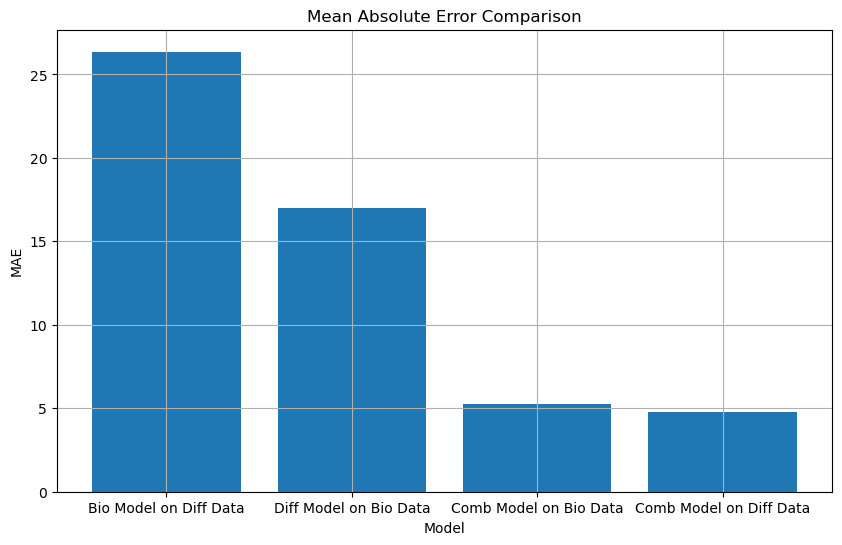

In [22]:
# ### Plot Mean Absolute Error Distribution

mae_scores = {
    'Bio Model on Diff Data': mae_bio_on_diff,
    'Diff Model on Bio Data': mae_diff_on_bio,
    'Comb Model on Bio Data': mae_comb_on_bio,
    'Comb Model on Diff Data': mae_comb_on_diff
}

plt.figure(figsize=(10, 6))
plt.bar(mae_scores.keys(), mae_scores.values())
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title("Mean Absolute Error Comparison")
plt.grid(True)
plt.show()
